# Part III - A: Analyzing Changing Trends in Academia - Paper Trends

# 0. Setup

Before we begin, make sure you have installed all the additional required Python packages. (The instructions below use pip. You can use easy_install, too.) Also, consider using virtualenv for a cleaner installation experience instead of sudo. 
* sudo pip install --upgrade altair
* sudo pip install --upgrade vega3
* sudo pip install --upgrade plotly
* sudo pip install --upgrade pycld2 # this package requires gcc

## 1. Paper Structure Dynamics

In the following subsection we will utilize the MAG and AMiner datasets to better understand how various paper characteristics, such as title, abstract, keywords, length, and references, change over time. We will start with analyzing how the number of published papers has changed over time. In this notebook, we will then check how various properties of papers have changed over time. We will use Altair and Seaborn Python packages to visualize the trends of papers' properties. Using these visualizations, we will analyze various papers' properties to understand how these properties have changed during the last century.
We will start with observing how the number of published papers has changed over time.

### 1.1. Number of Published Papers over Time

In the last 160 years there has been a massive surge in the number of publications. In this subsection, we will analyze the number of publications and the language of publications over time.

In [5]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [9]:
import pandas as pd
import numpy as np
import altair as alt
# alt.renderers.enable('notebook')
from ScienceDynamics.config.configs import *
from ScienceDynamics.visualization.visual_utils import *
import turicreate.aggregate as agg
from ScienceDynamics.utils import detect_lang, filter_sframe_by_func

In [11]:
from ScienceDynamics.datasets.microsoft_academic_graph import MicrosoftAcademicGraph
from ScienceDynamics.config.configs import DATASETS_BASE_DIR
mag = MicrosoftAcademicGraph(DATASETS_BASE_DIR / "MicrosoftAcademicGraph.zip")

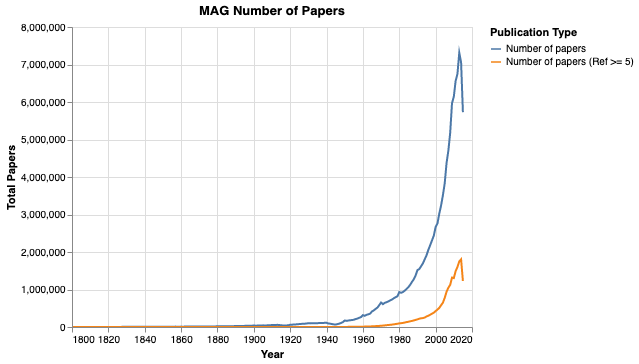

In [12]:
sf =  mag.extended_papers["Paper ID", "Paper publish year", 'Ref Number']
sf = sf.rename({"Paper publish year": "Year"})
g = sf.groupby("Year", {"Number of papers": agg.COUNT()})
sf2 = sf[sf['Ref Number'] >= 5]
g2 = sf2.groupby("Year", {"Number of papers (Ref >= 5)": agg.COUNT()}) # Papers with less 5 references can be reports, news, and letters
g = g.join(g2, how="left")

draw_features_yearly_chart_multi_lines(g, "Publication Type", "Total Papers", 1800, 2015, "MAG Number of Papers")

As you can see from the chart above, the number of papers has increased exponentially over the years. The decline from 2015 forward is probably due to missing papers in our dataset for years after 2014. Therefore, for the rest of this notebook, we will use only papers that were published before 2015. Next, let's observe the dominant paper languages over the years by analyzing title languages for all papers with at least 5 references:

In [13]:
sf = mag.extended_papers["Paper ID", "Original paper title", "Paper publish year"]
sf = sf.rename({"Paper publish year": "Year", "Original paper title":"Title"})
sf["Title Language"] = sf["Title"].apply(lambda t: detect_lang(t))
g = sf.groupby("Title Language", {"Number of Papers": agg.COUNT()})
g = g.sort("Number of Papers", ascending=False)
g

Less than 64 successfully started. Using only 25 workers.

All operations will proceed as normal, but lambda operations will not be able to use all available cores.

Using default 64 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"turicreate.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 128)"

Note that increasing the degree of parallelism also increases the memory footprint.

Title Language,Number of Papers
english,91694918
japanese,8408967
german,4154673
spanish,3823251
chinese,3483234
french,3326329
portuguese,1668233
korean,1450037
polish,1276150
russian,1104621


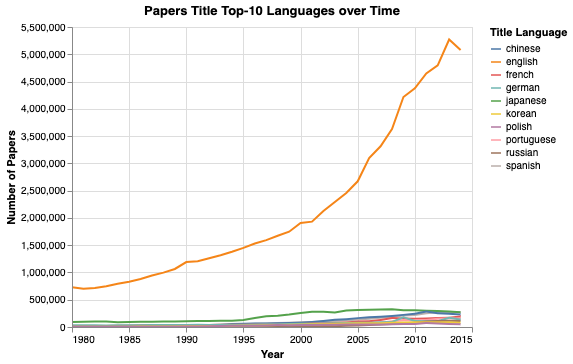

In [14]:
top_langs = set(g['Title Language'][:10])
sf = filter_sframe_by_years(sf,1980,2014)
sf = sf[sf["Title Language"].apply(lambda t: t in top_langs)]
g = sf.groupby(["Title Language", "Year"], {"Number of Papers": agg.COUNT()})
g = g.sort(["Year", "Number of Papers"], ascending=False)

chart = alt.Chart(g.to_dataframe(), title="Papers Title Top-10 Languages over Time").mark_line().encode(
    alt.X('Year:Q', axis=alt.Axis(format='d'), scale=alt.Scale(zero=False)),
    alt.Y('Number of Papers:Q', scale=alt.Scale(zero=False)),
    color="Title Language"
)
chart

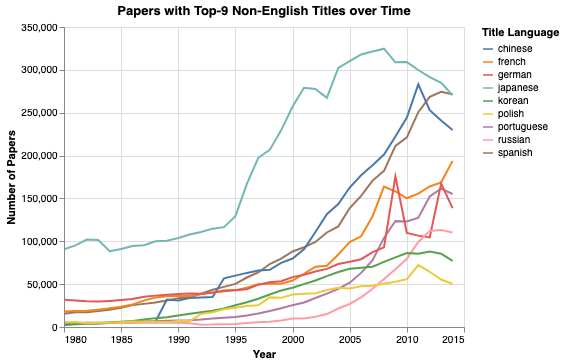

In [16]:
g = g[g["Title Language"] != "english"]
chart = alt.Chart(g.to_dataframe(), title="Papers with Top-9 Non-English Titles over Time").mark_line().encode(
    alt.X('Year:Q', axis=alt.Axis(format='d'), scale=alt.Scale(zero=False)),
    alt.Y('Number of Papers:Q', scale=alt.Scale(zero=False)),
    color="Title Language"
)
chart

It can be observed that since the 1980s there are more and more publications in different languages than English, such Japanese, Chinese, and Spanish.

### 1.2 Titles Trends

A paper’s title is among the first things one looks for before deciding to read a paper. Moreover, using the right title can help other researchers find the paper using search engines. In this subsection, we will analyze how papers' title lengths and properties have changed over time.

In [6]:
sf = tc.load_sframe(AMINER_PAPERS_SFRAME)["year","title", "lang"]
sf = sf.rename({"year":"Year"})
sf = sf[sf["lang"] == "en"]
sf.materialize()
sf["title_lang"] = sf["title"].apply(lambda t: detect_lang(t))
sf = sf[sf["title_lang"] == "english"]
sf.materialize()

In [7]:
#Second, papers with a short title 
sf["Title Length"] = sf["title"].apply(lambda t: len(t.split())) 

sf = sf[sf["Title Length"] > 1]
sf = sf[sf["Title Length"] < 50] # remove long titles that probably are results of problem in title parsing

#Lastly, filter papers taht were publish before 1850 or after 2014 (or have invalid publication year)
sf = sf[sf["Year"] <= 2014]
sf = sf[sf["Year"] >= 1850]
sf = sf.sort("Year") # 102489813 titles

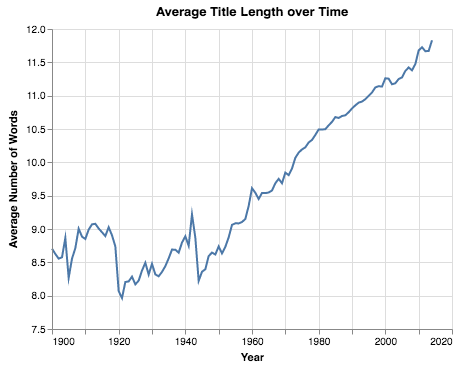

In [8]:
draw_feature_yearly_func_value(sf, "Title Length", "Average Number of Words", 1900, 2014, func_name="agg.AVG", 
                              title="Average Title Length over Time")

Let's check additional trends in papers' titles, such as the average word length and the usage of punctuation marks. We will start with calculating the average title word length over time:

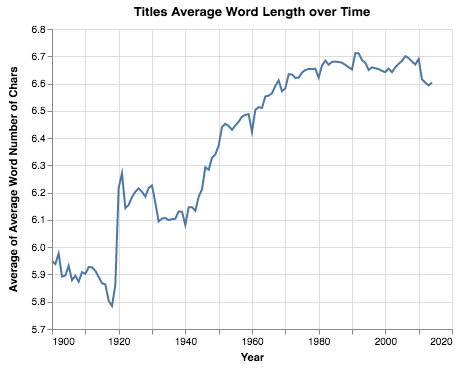

In [9]:
sf['Avg Word Number of Chars'] = sf["title"].apply(lambda t: np.average([len(w) for w in t.split()]))
draw_feature_yearly_func_value(sf, "Avg Word Number of Chars", "Average of Average Word Number of Chars", 1900, 2014, func_name="agg.AVG", title="Titles Average Word Length over Time")

In [10]:
sf

Year,title,lang,title_lang,Title Length,Avg Word Number of Chars
1850,Art. XXII.—The AnnualReport of the Board of ...,en,english,23,4.4347826087
1850,Lettre de Louis XIV (roide France) à de ...,en,english,10,4.3
1850,"The Patent Office, andReform of the Patent ...",en,english,9,4.44444444444
1850,"On the Construction of asmall Observatory, a new ...",en,english,26,5.53846153846
1850,"Notes on the monetarysystem, and Cinnamon ...",en,english,31,4.45161290323
1850,"Beautiful Kathleen,ballad ...",en,english,3,8.0
1850,Warren's Steel SpringChairs ...,en,english,4,6.25
1850,Art. XVIII.—Report ofthe Joint Special ...,en,english,44,5.65909090909
1850,[Small girl leaningagainst an overturned ...,en,english,24,4.79166666667
1850,ST. BARTHOLOMEW'SHOSPITAL Strumous ...,en,english,8,7.375


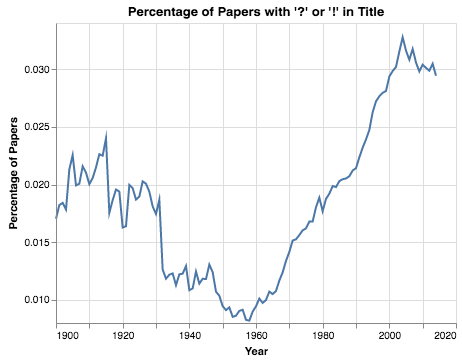

In [11]:
sf['mark'] = sf["title"].apply(lambda t: 1 if ('!' in t or '?' in t) else 0 )
draw_feature_yearly_func_value(sf, "mark", "Percentage of Papers", 1900, 2014, func_name="agg.AVG", title="Percentage of Papers with '?' or '!' in Title")

We can see that over the last years the usage of '?' and '!' in titles has increased. Let's look at some concrete examples of using interrobangs (?! and !?) in papers' titles:

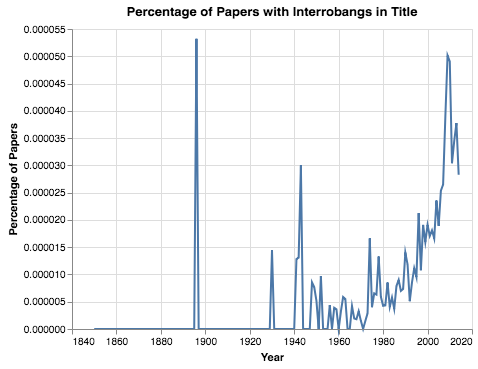

In [12]:
sf['bangs'] = sf["title"].apply(lambda t: 1 if ('!?' in t or '?!' in t) else 0 )
sf.materialize()
draw_feature_yearly_func_value(sf, "bangs", "Percentage of Papers", 1850, 2014, func_name="agg.AVG", title="Percentage of Papers with Interrobangs in Title")

In [13]:
sf[sf["bangs"] == 1]["title"][1000:1100]

dtype: str
Rows: 100
["Quantum Wellness: Oprah Winfrey Vegan?! 21-Day 'Cleanse'", "Cobb County Voodoo?! Annette Kesting Wanted Opponent 'Cursed'", 'What the #$%?!: the Life Cycle of Censorship in Young Adult Literature', 'Appendix E: What Can Be Done to Create a Wow!?', 'Combating routing holes by means of mobile nodes: Should energy really matter!?', 'Rural Entrepreneurship – Aggregation Factor of Local Stakeholders!?', 'I have broadband. Now what?!', 'ロケーションがすべて!? (Summary december 2007 米国版『Journal of Financial Planning』)', 'Asks the Chief Engineer: "So what do I go do?!" [1]', '$32 for a movie?!', 'Angelina Jolie Building 12 Children Apostle Cult?!', 'Trees = Networks ?!?', 'Fake or Real!!?? Have your say!!!: Negotiating authenticity on Australian Idol', 'Will Smith Gay?! Madame reveals Jada Pinkett, Smith Sex Orders', 'Angelina Jolie Breast Photos by Brad Pitt?!', 'Photo: Jenna Jameson Pregnant With Tito Ortiz Baby?! OMG!', 'Photo: Usher, Grace Miguel Affair?!', 'P0784 CAN YOU PREV

It can be observed that over time papers' titles have become longer both by adding more words to the title and by using more characters in each word. Moreover, over time more and more titles use question and exclamation marks. We can assume that using these marks can make the titles more attractive, to convince other researchers to read the paper.

### 1.3 Trends in Number and Order of Authors

It is well-known that papers' average number of authors has increased sharply in recent years. Let’s use our datasets to validate this observation and explore how the importance of the order of authors has changed over time.

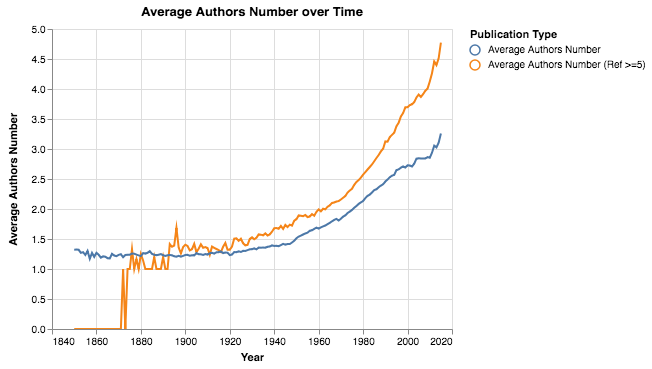

In [14]:
sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)[ "Paper publish year", 'Authors List Sorted', 'Authors Number', "Ref Number"]
sf = sf.rename({"Paper publish year": "Year"})
g = sf.groupby( "Year", {"Average Authors Number": agg.AVG('Authors Number')})


sf2 = sf[sf['Ref Number'] >= 5]
g2 = sf2.groupby("Year", {"Average Authors Number (Ref >=5)": agg.AVG('Authors Number')})
g = g.join(g2, how="left")
draw_features_yearly_chart_multi_lines(g, "Publication Type", "Average Authors Number", 1850, 2015, title="Average Authors Number over Time")

As we can perceive, the average number of authors per paper has increased sharply over recent years. Let's examine how the maximal number of authors per year has changed.

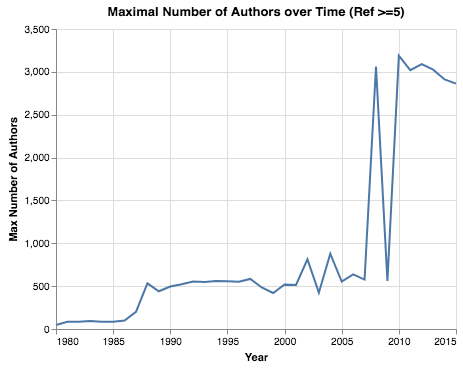

In [15]:
g2 = sf2.groupby("Year", {"Maximal Number of Authors (Ref >=5)": agg.MAX('Authors Number')})
draw_feature_yearly_func_value(sf2, "Authors Number", "Max Number of Authors", 1980, 2015, func_name="agg.MAX", title="Maximal Number of Authors over Time (Ref >=5)")

In [16]:
sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)[ "Paper publish year", 'Authors Number', "Ref Number", "Original paper title"]
sf2 = sf[sf['Ref Number'] >= 5]
sf2.sort('Authors Number', ascending=False)

Paper publish year,Authors Number,Ref Number,Original paper title
2010,3188,8,Charged-particlemultiplicities in pp ...
2010,3162,7,Performance of the ATLASDetector using First ...
2010,3140,32,Measurement of inclusivejet and dijet cross ...
2012,3091,6,Search for heavy vector-like quarks coupling to ...
2008,3063,161,The CMS experiment at theCERN LHC ...
2012,3031,23,Jet mass and substructureof inclusive jets in ...
2012,3030,21,Search for same-sign top-quark production and ...
2013,3026,53,Jet energy measurementwith the ATLAS detector ...
2012,3023,18,Measurement of the WWcross section in pp ...
2011,3020,11,Measurement of theproduction cross section ...


We can notice that in recent years more and more papers were written by thousands of authors who worked together on extremely large projects. While it is clear that the average number of authors per paper has increasingly grown in recent years, there is an additional interesting aspect regarding the papers' author lists - the order of the names in the list.
Let's view how the order of the authors list has changed over time and check if alphabetic order is the most common order.


In [17]:
def get_last_names_list(l):
    last_names_list = []
    for d in l:
        n = d['name'].split()
        if len(n) < 2:
            return None
        last_names_list.append(n[-1])
    return last_names_list
        
sf = tc.load_sframe(AMINER_PAPERS_SFRAME)['year','authors', 'lang']
sf = sf[sf["lang"] == "en"]
sf['authors_number'] = sf['authors'].apply(lambda l: len(l))
sf = sf[sf['authors'] != None]
sf = sf[sf['authors_number'] > 1]
sf['author_last_names'] = sf['authors'].apply(lambda l: get_last_names_list(l) )
sf = sf[sf['author_last_names'] != None]
sf.materialize()
sf

year,authors,lang,authors_number,author_last_names
1965,"[{'name': 'G. Adam'},{'name': 'K. Schreibe ...",en,2,"[Adam, Schreiber]"
None,"[{'name': 'R. Farahbod'},{'name': 'V. Gervasi'}, ...",en,4,"[Farahbod, Gervasi,Glasser, Memon] ..."
2011,"[{'name': 'PeijuanWang'}, {'name': 'Jiahua ...",en,5,"[Wang, Zhang, Xie, Xu,Xu] ..."
2007,"[{'name': 'D J Lum'},{'name': 'V Upadhyay'}, ...",en,4,"[Lum, Upadhyay, Smith,McFarlane] ..."
2005,"[{'name': 'FTHOUVENYPAISANT'}, ...",en,6,"[THOUVENYPAISANT, KONATE,AUBE, LEBIGOT, OBERTI, ..."
2000,"[{'name': 'Asami Nakai'},{'name': 'Akio Ohtani'}, ...",en,7,"[Nakai, Ohtani, Ohki,Osada, Iwamoto, Hamada, ..."
2011,"[{'org': 'Department ofBiology, Faculty of ...",en,2,"[Arda-Pirincci, Bolkent]"
2004,"[{'name': 'TatsuoKanda'}, {'name': 'Osamu ...",en,5,"[Kanda, Yokosuka,Imazeki, Saisho, Nagao] ..."
2008,"[{'name': 'CarmenSandoval C'}, {'name': ...",en,6,"[C, F, Lizama, S, V, H]"
1996,[{'org': 'Division ofApplied Sciences and ...,en,7,"[Eriksson, Beck, Topinka,Katine, Westervelt, ..."


Let's check the percentage of papers in which the authors appear in alphabetical order:

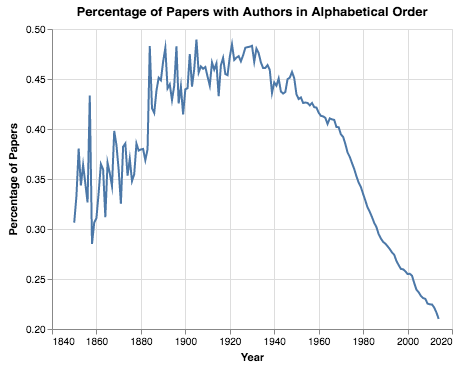

In [18]:
def is_alphabetical_order(l):
    for i in range(len(l) - 1):
        if l[i] > l[i+1]:
            return 0
    return 1
sf['is_alphabetical_order'] = sf['author_last_names'].apply(lambda l: is_alphabetical_order(l))
sf = sf.rename({"year": "Year"})
sf = sf.rename({"authors_number": "Authors Number"})
draw_feature_yearly_func_value(sf, "is_alphabetical_order", "Percentage of Papers", 1850, 2014, func_name="agg.AVG", title="Percentage of Papers with Authors in Alphabetical Order")

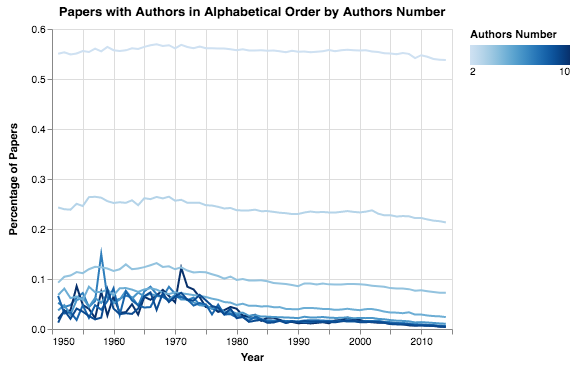

In [19]:
g = sf.groupby(['Year', "Authors Number"], {"Percentage of Papers": agg.AVG("is_alphabetical_order")})
g = g.sort(["Authors Number", "Year"] )
g = g[g["Year"] <= 2014]
g = g[g["Year"] > 1950 ]
g = g[g["Authors Number"] <= 10]
df = g.to_dataframe()
df = df.fillna(0)
df = df.sort_values(by=['Year'])

chart = alt.Chart(df, title="Papers with Authors in Alphabetical Order by Authors Number").mark_line().encode(
    alt.X('Year:Q', axis=alt.Axis(format='d'), scale=alt.Scale(zero=False)),
    alt.Y("Percentage of Papers:Q", scale=alt.Scale(zero=False)),
    color="Authors Number"
)
chart

We can observe that over the years there has been a decline in the usage of alphabetical order. Additionally, we can observe that the usage of alphabetical order sharply decreases in cases where there are 3 or more authors who wrote the paper.

### 1.4 Trends in Abstract Length

In many cases, the abstract section is one of the first sections a researcher looks at before deciding to read the paper. Therefore, a better abstract can improve the number of reads a paper gets. Let's check how the length of papers' abstract sections has changed over time.

In [20]:
sf = tc.load_sframe(AMINER_PAPERS_SFRAME)["year","abstract", "lang"]
sf = sf[sf["lang"] == "en"] # only abstract of English papers
sf = sf[sf["lang"] != None]
sf["Number of Words in Abstracts"] = sf['abstract'].apply(lambda a: len(a.split()))
sf = sf[sf["Number of Words in Abstracts"] > 10]  #  remove short abstaract
sf = sf[sf["Number of Words in Abstracts"] <= 2000] #  remove long abstaract
sf.materialize()

sf["abstract_lang"] = sf["abstract"].apply(lambda t: detect_lang(t))
sf = sf[sf["abstract_lang"] == "english"]
sf = sf.rename({"year": "Year"})
sf.materialize()


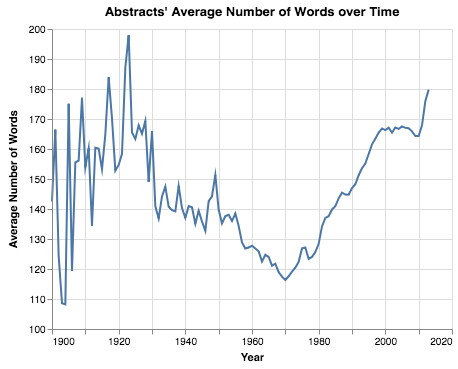

In [21]:
draw_feature_yearly_func_value(sf["Year", "Number of Words in Abstracts"] , "Number of Words in Abstracts", "Average Number of Words", start_year=1900, end_year=2013, func_name="agg.AVG",title="Abstracts' Average Number of Words over Time")

/home/michael/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


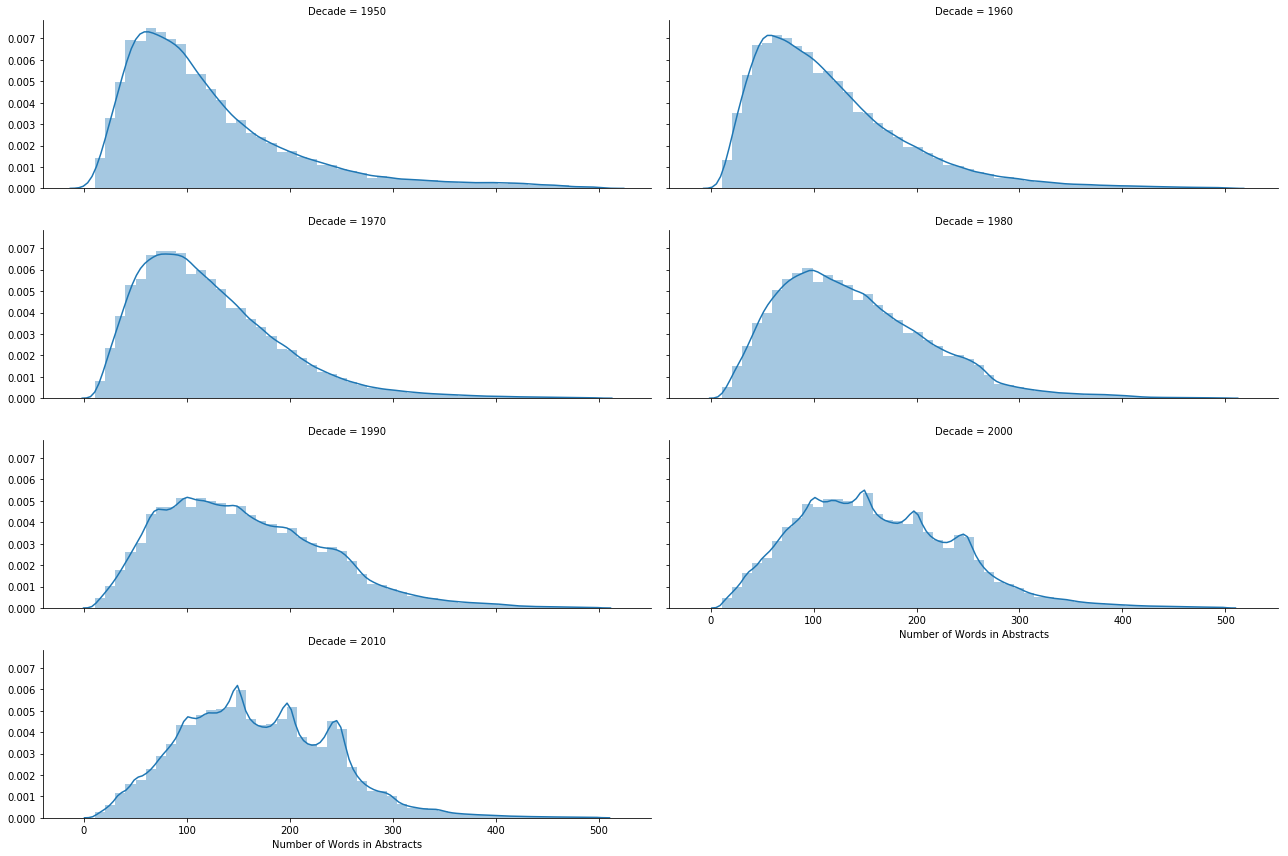

In [22]:
sf = sf[sf["Number of Words in Abstracts"] <= 500]
draw_features_decade_dist(sf, "Number of Words in Abstracts", 1950, 2013, col_warp=2, sharex=True, sharey=True)

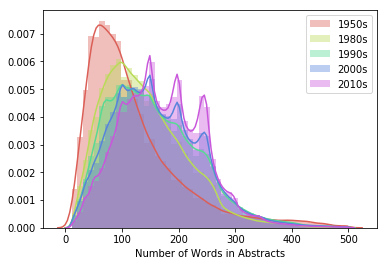

In [23]:
decades_list = [1950, 1980, 1990, 2000, 2010]
draw_layered_hist(sf, "Number of Words in Abstracts", decades_list, 1920, 2014)

From the above figures, it can be observed that over time abstracts have become longer. In the 1950s, most abstracts were less than 100 words. In recent decades, most abstracts have over 100 words, and more and more abstracts contain between 200 and 300 words.

### 1.5 Keywords Trends

Papers' keywords are very helpful for understanding the general topic of a paper, and they make it easier to search for a paper on a specific topic. Let's check how the usage of keywords has changed over the years.

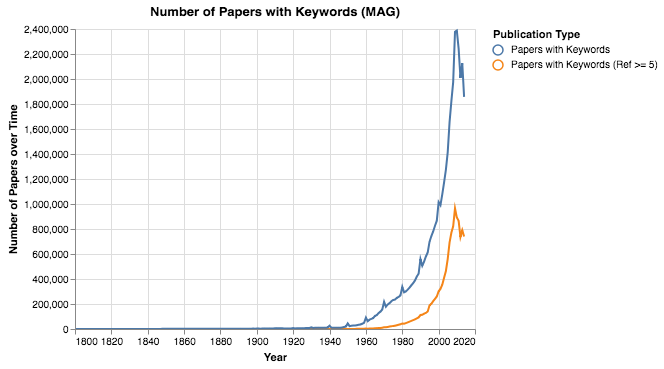

In [24]:
sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)["Paper publish year", "Keywords List", 'Ref Number', "Journal ID mapped to venue name"]
sf = sf.rename({"Paper publish year": "Year"})
sf = sf.fillna("Keywords List", [])
sf["Keywords Number"] = sf["Keywords List"].apply(lambda l: len(l))
k_sf = sf[sf["Keywords Number"] <= 20] # remove papers with too many keywords 
k_sf['has_keywords'] = k_sf["Keywords List"].apply(lambda l: 1 if len(l) > 0 else 0)


has_k_sf = k_sf[k_sf['has_keywords']]
g = has_k_sf.groupby("Year", {"Papers with Keywords ": agg.COUNT()})
sf2 = has_k_sf[has_k_sf['Ref Number'] >= 5]
g2 = sf2.groupby("Year", {"Papers with Keywords (Ref >= 5)": agg.COUNT()})
g = g.join(g2, how="left")
draw_features_yearly_chart_multi_lines(g, "Publication Type", "Number of Papers over Time", 1800, 2014,title="Number of Papers with Keywords (MAG)")

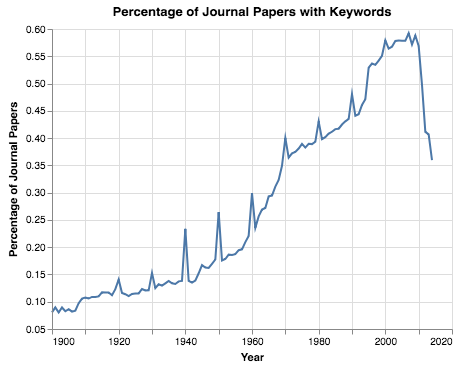

In [25]:
j_sf = k_sf[k_sf["Journal ID mapped to venue name"] != '']
draw_feature_yearly_func_value(j_sf, "has_keywords", "Percentage of Journal Papers", 1900, 2014, func_name="agg.AVG", title="Percentage of Journal Papers with Keywords")

In the last century the percentage of papers' containing keywords has skyrocketed. However, since 2010, we can see a decline in the percentage of journal papers containing keywords. Similar observations also can be found in the AMiner dataset:

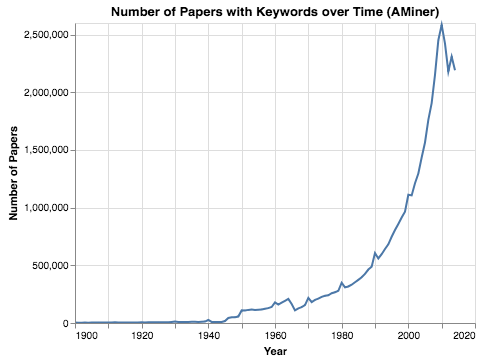

In [26]:
a_sf = tc.load_sframe(AMINER_PAPERS_SFRAME)["year", "keywords", "lang", "venue"]
a_sf = a_sf[a_sf["keywords"] != None]
a_sf = a_sf[a_sf["lang"] == "en"]
a_sf = a_sf.rename({"year": "Year", "keywords": "Keywords"})
g = a_sf.groupby("Year", {"Number of Papers": agg.COUNT()})
draw_features_yearly_chart(g, "Number of Papers", 1900, 2014, title="Number of Papers with Keywords over Time (AMiner)")

In [27]:
sf = a_sf[a_sf["Year"] == 2013]
sf = sf[sf["venue"] != None]
g = sf.groupby("venue", {"Number of Papers without Keywords (2013)": agg.COUNT()})
g.sort("Number of Papers without Keywords (2013)", ascending=False)

venue,Number of Papers withoutKeywords (2013) ...
PloS one,27912
Advanced MaterialsResearch ...,23966
Applied Mechanics andMaterials ...,22448
Journal of the PhysicalSociety of Japan ...,5967
Nature,5179
Proceedings of theNational Academy of ...,4409
Procedia - Social andBehavioral Sciences ...,3171
The Journal of biologicalchemistry ...,3001
Cheminform,2880
Proceedings of SPIE - TheInternational Society ...,2838


According to the above table, indeed many of the papers published in top journals in 2013 didn't contain keywords. This could be a result of format limitations or missing data in the dataset. For example, we can observe that many of the PLOS ONE papers don't have any keywords. Yet PLOS ONE papers and their matching keywords (defined as subject areas) are presented on the PLOS ONE website. However, from our observation these subject areas don't appear in the papers' PDF versions. Let's check how the average number of keywords per paper has changed over time.

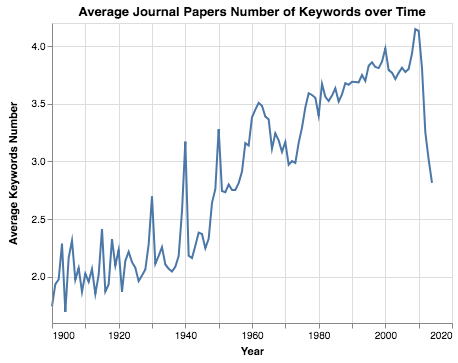

In [28]:
#Only MAG Journal Papers 
j_sf = k_sf[k_sf["Keywords Number"] != 0]
draw_feature_yearly_func_value(j_sf, "Keywords Number", "Average Keywords Number", 1900, 2014, func_name="agg.AVG",title="Average Journal Papers Number of Keywords over Time")


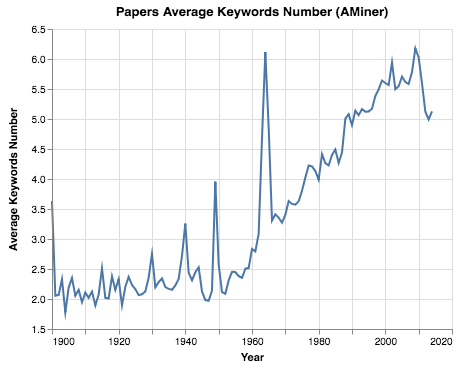

In [29]:
#AMiner papers
a_sf["Keywords Number"] = a_sf["Keywords"].apply(lambda l: len(l))
draw_feature_yearly_func_value(a_sf, "Keywords Number", "Average Keywords Number", 1900, 2014, func_name="agg.AVG", title="Papers Average Keywords Number (AMiner)")

/home/michael/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:2560: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  tz=getattr(series.dtype, 'tz', None))


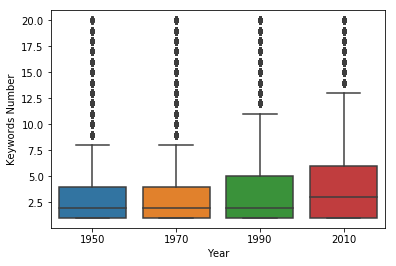

In [30]:
years = set([1950,1970,1990, 2010])
sf = k_sf[k_sf["Year"].apply(lambda y: y in years)]["Year","Keywords Number"]
sf = sf[sf["Keywords Number"] <= 20]
sf = sf[sf["Keywords Number"] > 0]
sns.boxplot(x="Year", y="Keywords Number", data=sf.to_dataframe())

### 1.6 Multidisciplinary Research Trends

The MAG dataset maps each keyword with its matching field of study. Moreover, the dataset also contains the hierarchical order among the various fields of study. In our study, we used this hierarchical order to observe and measure the number of multidisciplinary papers that contain keywords from two or more different research fields.

In [31]:
f_sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)['Paper publish year',"Keywords List", "Fields of study parent list names (L1)", "Fields of study parent list (L1)",
                                             "Fields of study parent list names (L0)", "Fields of study parent list (L0)"]
f_sf = f_sf.rename({"Paper publish year": "Year"})
f_sf = f_sf[f_sf["Fields of study parent list (L1)"] != None]
f_sf = f_sf.fillna("Fields of study parent list (L1)", [])
f_sf["Number of L1 Fields"] = f_sf["Fields of study parent list (L1)"].apply(lambda l: len(l))
f_sf["Number of L0 Fields"] = f_sf["Fields of study parent list (L0)"].apply(lambda l: len(l))
f_sf = f_sf[f_sf["Fields of study parent list (L0)"] != None]
f_sf = f_sf.fillna("Fields of study parent list (L0)", [])
f_sf = f_sf[f_sf["Number of L1 Fields"] <= 10 ] # limit the number of paperes with too many research fields
f_sf["Multidisciplinary Research"] = f_sf["Fields of study parent list (L0)"].apply(lambda l: 1 if  len(l) >=2 else 0)
f_sf.materialize()
f_sf["Keywords List", "Fields of study parent list names (L0)", "Fields of study parent list names (L1)"]

Keywords List,Fields of study parentlist names (L0) ...,Fields of study parentlist names (L1) ...
"[measures, softwaremeasurement, autonomy, ...","[Computer Science,Sociology, Mathematics, ...","[Law, Data mining,Artificial intelligence, ..."
"[optimization problem,probability density] ...",[Mathematics],[Statistics]
"[process algebra, processcalculi, multi agent ...",[Computer Science],"[Immunology, Programminglanguage, Artificial ..."
"[cognition, computationallinguistics, grammars, ...","[Computer Science,Psychology] ...","[Programming language,Natural language ..."
"[computer aided design,cad, ontologies] ...",[Computer Science],[Artificial intelligence]
"[dynamic system, dynamicsystems, neural network ...","[Computer Science,Chemistry] ...",[Machine learning]
[multiobjectiveoptimization] ...,[],[Mathematicaloptimization] ...
"[comparative study,bayesian network, ...","[Computer Science,Sociology] ...","[Machine learning, Socialscience] ..."
"[natural languageprocessing, cognitive ...",[Computer Science],"[Machine learning,Natural language ..."
"[feature selection,visualization, ...",[Computer Science],[Machine learning]


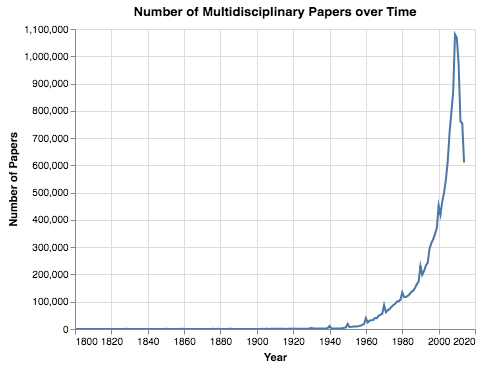

In [32]:
g = f_sf[f_sf["Multidisciplinary Research"]]["Year", "Multidisciplinary Research"]
g = g.groupby("Year", {"Number of Papers": agg.COUNT()})
draw_features_yearly_chart(g, "Number of Papers", 1800, 2014, title="Number of Multidisciplinary Papers over Time")

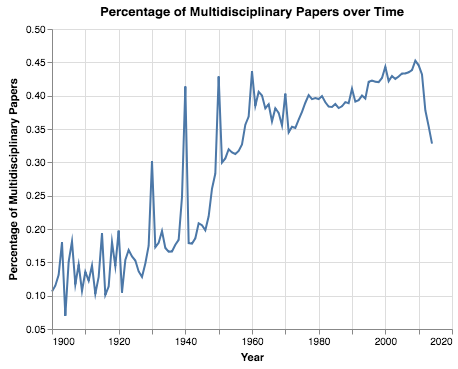

In [33]:
draw_feature_yearly_func_value(f_sf, "Multidisciplinary Research", "Percentage of Multidisciplinary Papers", 1900, 2014, func_name="agg.AVG",title="Percentage of Multidisciplinary Papers over Time")

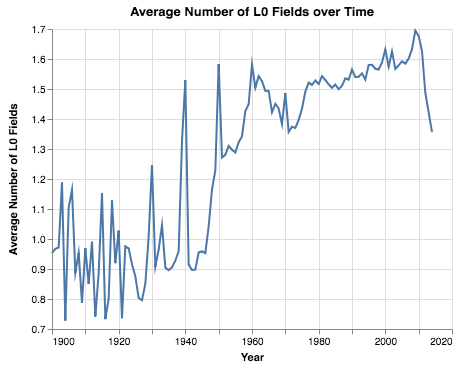

In [34]:
draw_feature_yearly_func_value(f_sf, "Number of L0 Fields", "Average Number of L0 Fields", 1900, 2014, func_name="agg.AVG", title="Average Number of L0 Fields over Time")

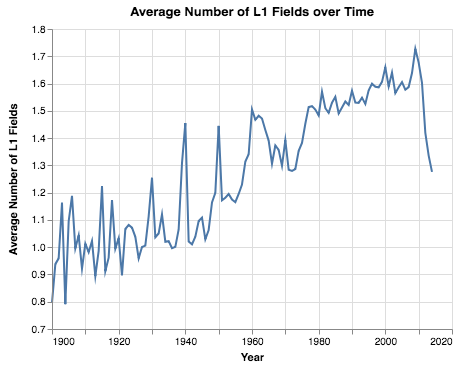

In [35]:
draw_feature_yearly_func_value(f_sf, "Number of L1 Fields", "Average Number of L1 Fields", 1900, 2014, func_name="agg.AVG",title="Average Number of L1 Fields over Time")

As it can be observed from the above charts, over the last century the overall number of multidisciplinary papers and the average number of research fields per publication considerably increased until 2010. Then, in 2010 there is a sharp decrease probably due to the decrease in papers with keywords, or due to other factors. Nevertheless, it clear that during the last century considerably more multidisciplinary publications have been published.

### 1.7 Trends in Papers' Number of References

Let's check how the characteristics of papers have changed over time. We start with examining how the number of references have changed over the years.

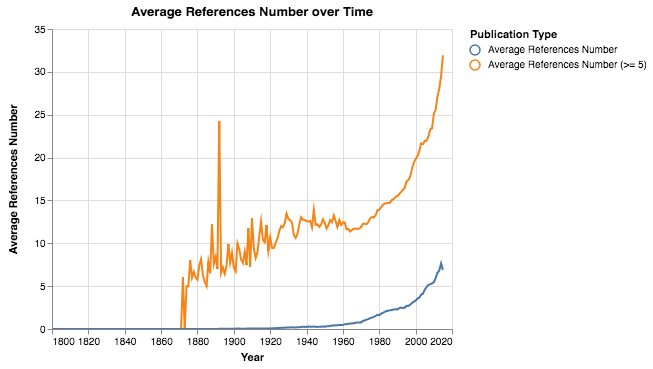

In [36]:
sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)["Paper publish year", "Ref Number"]
sf = sf.rename({"Paper publish year": "Year"})
g = sf.groupby("Year", {"Average References Number": agg.AVG("Ref Number")})

sf2 = sf[sf['Ref Number'] >= 5]
g2 = sf2.groupby("Year", {"Average References Number (>= 5)": agg.AVG("Ref Number")})
g = g.join(g2, how="left")
draw_features_yearly_chart_multi_lines(g, "Publication Type", "Average References Number", 1800, 2015, title="Average References Number over Time")

Let's use the Seaborn package to visualize how the distributions of citations have changed over the past decades. Looking at the data, we can observe there are many papers with hundreds and even thousands of references. However, most papers have far fewer citations. We will zoom in on papers that have between 5 and 100 references and observe how the number of citations has changed over time.


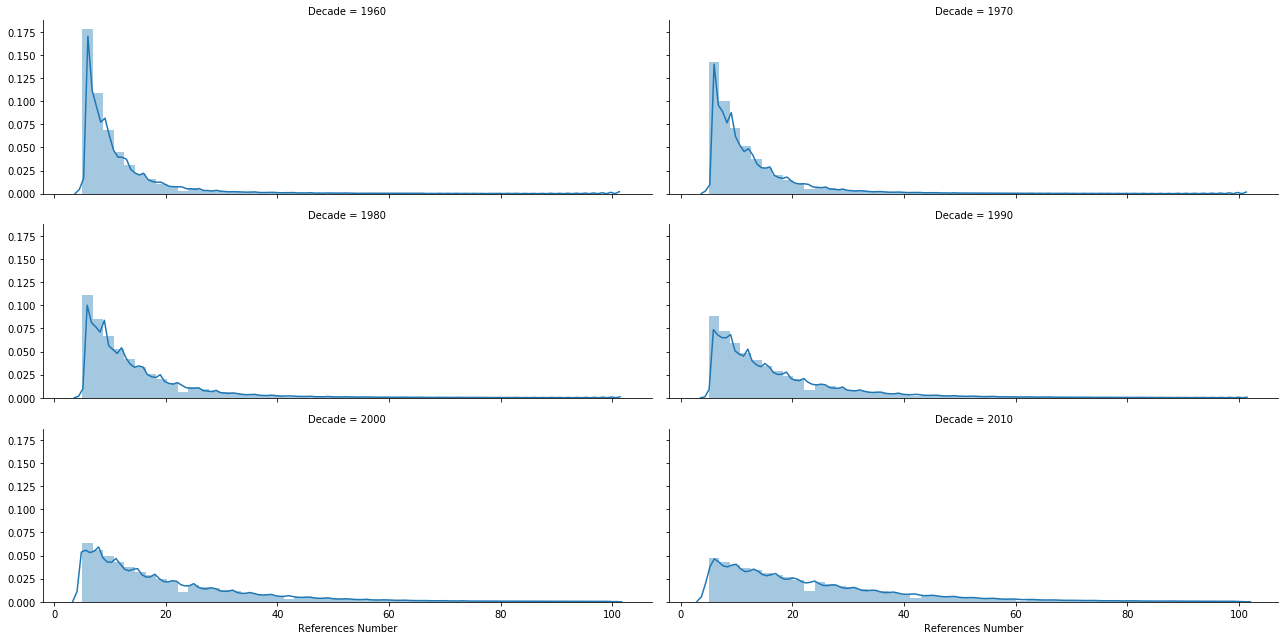

In [37]:
sf = sf[sf["Ref Number"] <= 100]
sf = sf[sf["Ref Number"] >= 5]
sf = sf.rename({"Ref Number": "References Number"})
draw_features_decade_dist(sf, "References Number", 1960, 2013, col_warp=2, sharex=True, sharey=True)

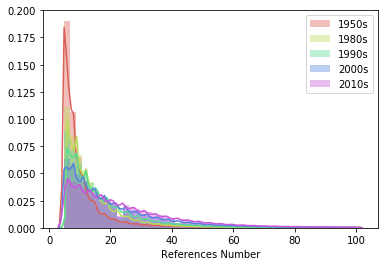

In [38]:
decades_list = [1950, 1980, 1990, 2000, 2010]
draw_layered_hist(sf, "References Number", decades_list, 1950, 2014)

It can be observed that over time the percentage of papers with higher numbers of references has increased, especially in the last two decades. For example, while in 1960 only a few papers had over 20 references, since 2010 it is quite common to find papers with over 20 references. Moreover, while in the 1990s there were only a few papers with over 40 references, in recent years not only have a high number of papers been published each year, but also a higher percentage of them contains over 50 references.
In the next subsection, we will be focusing on how the number of self-citations has changed over time.



### 1.8 Self-Citation Trends

Various papers claim that in recent years there has been a surge in the usage of self-citations. Let's widely check this claim using the MAG dataset and analyzing the self-citation number over time for papers with at least 5 references.

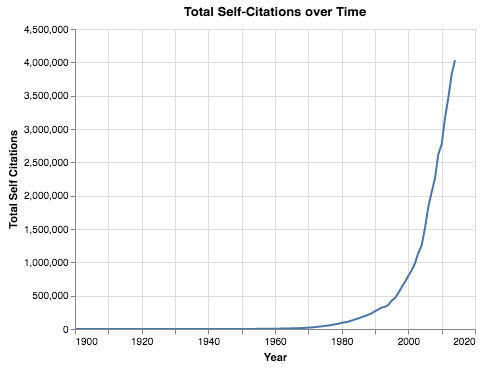

In [39]:
sf = tc.load_sframe(EXTENDED_PAPER_REFERENCES_SFRAME)
sf["Is Self Citation"] = sf["self citation"].apply(lambda i: 1 if i > 0 else 0)
sf2 = tc.load_sframe(EXTENDED_PAPERS_SFRAME)["Paper ID", "Paper publish year", "Ref Number"]
sf2 = sf2[sf2["Ref Number"] >= 5]
sf2 = sf2.rename({"Paper publish year":"Year"})
s_sf = sf.join(sf2)
g = s_sf.groupby("Year", {"Total Self Citations": agg.SUM("Is Self Citation")})
draw_features_yearly_chart(g, "Total Self Citations", 1900, 2014, title="Total Self-Citations over Time")

As can be seen in the above chart, the overall number of self-citations has exponentially grown over the last century. Let's observe how the average number of self-citations per paper has changed over the years.

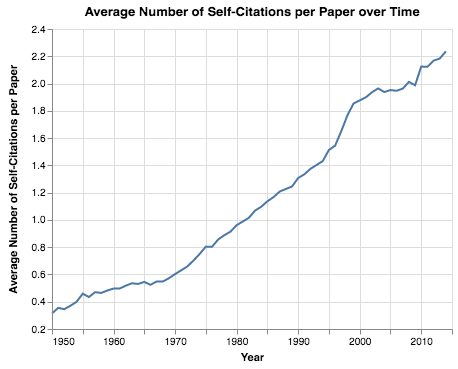

In [40]:
g = s_sf.groupby(["Year", "Paper ID", "Ref Number"], {"Total Self Citations": agg.SUM("Is Self Citation")})
draw_feature_yearly_func_value(g, "Total Self Citations", "Average Number of Self-Citations per Paper", 1950, 2014, func_name="agg.AVG", title="Average Number of Self-Citations per Paper over Time")

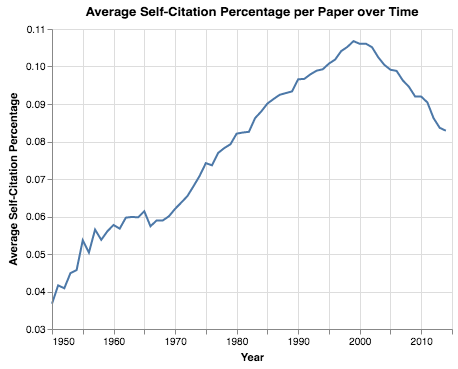

In [41]:
g["Self Citation Ratio"] = g.apply(lambda r: r["Total Self Citations"]/float(r["Ref Number"]))
draw_feature_yearly_func_value(g, "Self Citation Ratio", "Average Self-Citation Percentage", 1950, 2014, func_name="agg.AVG", title="Average Self-Citation Percentage per Paper over Time")

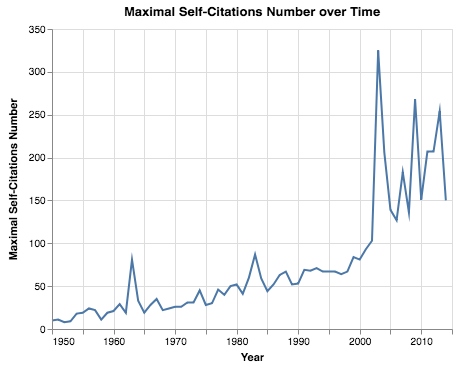

In [42]:
draw_feature_yearly_func_value(g, "Total Self Citations", "Maximal Self-Citations Number", 1950, 2014, func_name="agg.MAX", title="Maximal Self-Citations Number over Time")

As can be observed from the above charts, the average number of self-citations has increased over the last century from about a single self-citation per paper in the 1980s to over 2.2 self-citations per paper in 2014. Moreover, in recent years there are papers with over 200 self-citations. However, due to the increase in the total number of references per paper, the overall percentage of self-citation references has decreased in recent years.

### 1.9 Trends in Paper Length

We can use the papers that appear in both the MAG and AMiner datasets to calculate how papers’ lengths have changed over time. We first calculate the average paper lengths over time. Then, we calculate the average and median lengths of only journal papers over time.

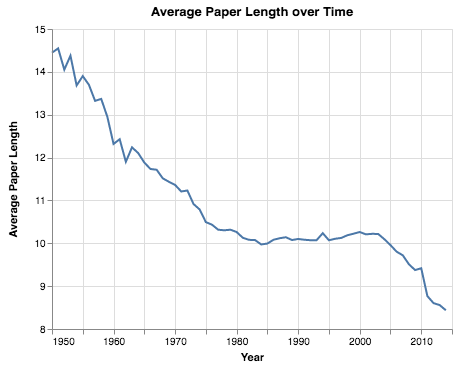

In [43]:
#first we filter papers with no page start or page end values
def convert_to_int(i):
    try:
        return int(i)
    except:
        return None

am_sf = tc.load_sframe(AMINER_PAPERS_SFRAME)["year", "page_start", "page_end","references"]
am_sf["Ref Number"] = am_sf["references"].apply(lambda l: len(l))
am_sf = am_sf[am_sf["Ref Number"] >= 5] 
# Calculating papers length 
am_sf['page_start'] = am_sf['page_start'].apply(lambda p: convert_to_int(p))
am_sf['page_end'] = am_sf['page_end'].apply(lambda p: convert_to_int(p))
am_sf = am_sf[am_sf['page_start'] != None]
am_sf = am_sf[am_sf['page_end'] != None]
am_sf['Paper Length'] = am_sf.apply(lambda p: p['page_end'] - p['page_start'] + 1)
am_sf = am_sf.rename({"year": "Year"})
am_sf = am_sf[am_sf["Paper Length"] > 0]
am_sf = am_sf[am_sf["Paper Length"] <= 2000] # removing papers with error parsed page numbers

draw_feature_yearly_func_value(am_sf, "Paper Length", "Average Paper Length", 1950, 2014, func_name="agg.AVG", title="Average Paper Length over Time")

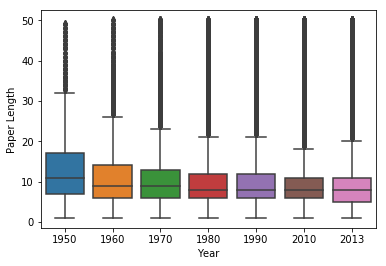

In [44]:
years = set([1950,1960, 1970,1980, 1990, 2010, 2013])
sf = am_sf[am_sf["Year"].apply(lambda y: y in years)]["Year","Paper Length"]
sf = sf[sf["Paper Length"] <= 50]
sns.boxplot(x="Year", y="Paper Length", data=sf.to_dataframe())

According to the above charts, it seems that with time the average and median lengths of papers has decreased.

### 1.10 Papers with No Citations

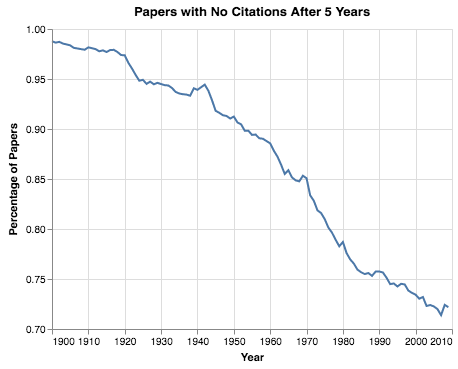

In [45]:
def no_citations_after_years(citations_dict, year,after_years=5):
    if citations_dict is None:
        return 1
    l = [v for k,v in citations_dict.iteritems() if (int(k) <= (year + after_years))]
    if len(l) > 0:
        return 0
    return 1
        
m_sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)["Paper publish year" , "Ref Number", "Total Citations by Year", "Total Citations by Year without Self Citations"]
m_sf = m_sf.rename({"Paper publish year":"Year"})
m_sf["No Citations After 5 Years"] = m_sf.apply(lambda r: no_citations_after_years(r["Total Citations by Year"], r["Year"]))
m_sf.materialize()
draw_feature_yearly_func_value(m_sf, "No Citations After 5 Years", "Percentage of Papers", 1900, 2009, func_name="agg.AVG", title="Papers with No Citations After 5 Years")

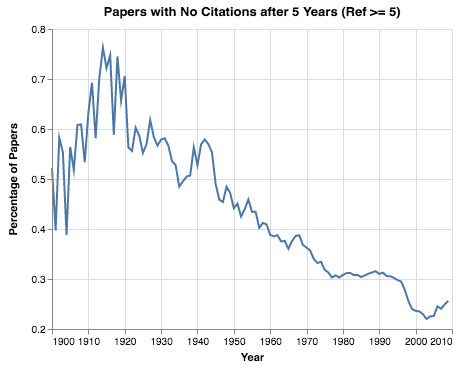

In [46]:
m_sf = m_sf[m_sf["Ref Number"] >= 5]

draw_feature_yearly_func_value(m_sf, "No Citations After 5 Years", "Percentage of Papers", 1900, 2009, func_name="agg.AVG", title="Papers with No Citations after 5 Years (Ref >= 5)")

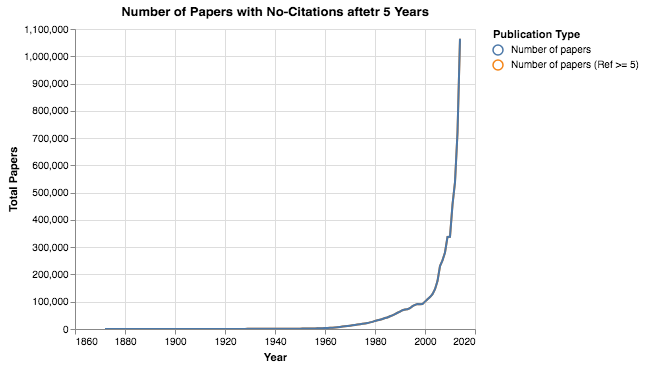

In [47]:
no_sf = m_sf[m_sf["No Citations After 5 Years"] == 1]
g = no_sf.groupby("Year", {"Number of papers": agg.COUNT()})
sf2 = no_sf[no_sf['Ref Number'] >= 5]
g2 = sf2.groupby("Year", {"Number of papers (Ref >= 5)": agg.COUNT()}) # Papers with less 5 references can be reports, news, and letters
g = g.join(g2, how="left")

draw_features_yearly_chart_multi_lines(g, "Publication Type", "Total Papers", 1800, 2014, "Number of Papers with No-Citations aftetr 5 Years")


In both charts, there is a steady decline in the number of papers with no citations after 5 years. However, even with this decline, over 70% of all published papers don't receive any citations, and over 20% of all papers with at least 5 references don't receive any citations. Let's repeat this calculation by not considering self-citations.

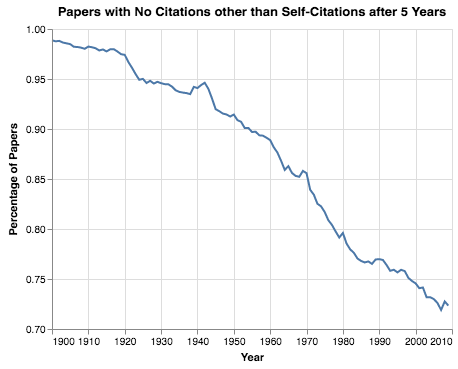

In [48]:
m_sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)["Paper publish year" , "Ref Number", "Total Citations by Year", "Total Citations by Year without Self Citations"]
m_sf = m_sf.rename({"Paper publish year":"Year"})
m_sf["No Citations After 5 Years"] = m_sf.apply(lambda r: no_citations_after_years(r["Total Citations by Year without Self Citations"], r["Year"]))
m_sf.materialize()
draw_feature_yearly_func_value(m_sf, "No Citations After 5 Years", "Percentage of Papers", 1900, 2009, func_name="agg.AVG",title="Papers with No Citations other than Self-Citations after 5 Years")

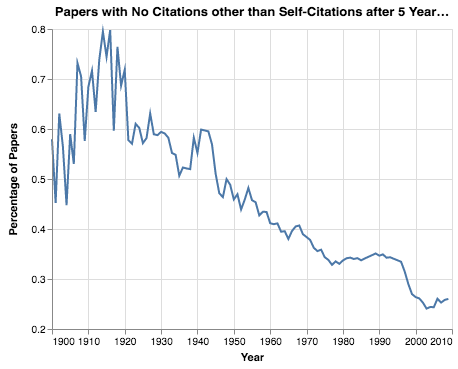

In [49]:
m_sf = m_sf[m_sf["Ref Number"] >= 5]
draw_feature_yearly_func_value(m_sf, "No Citations After 5 Years", "Percentage of Papers", 1900, 2009, func_name="agg.AVG", title="Papers with No Citations other than Self-Citations after 5 Years (Ref >=5)")

These results indicate that each year huge amounts of resources are being spent on papers that probably have a limited impact. Nevertheless, even though the total number of uncited papers has increased over the years, the percentage of uncited papers has decreased.

### 1.11 Citation Distribution Trends

In [50]:
selected_decades = {1950,1960, 1970, 1980, 1990, 2000}
sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)['Total Citations by Year',"Paper publish year", "Ref Number"]
sf = sf[sf["Ref Number"] >= 5]
sf = sf.fillna('Total Citations by Year', {})
sf  = sf.rename({"Paper publish year": "Year"})
sf["Decade"] = sf["Year"].apply(lambda y: y- y%10)
sf = sf[sf["Decade"].apply(lambda decade: decade in selected_decades)]

sf['Total Citations by Year'] = sf['Total Citations by Year'].apply(lambda d: {int(k):v for k,v in d.iteritems()})
sf['Total Citations'] = sf.apply(lambda r: {int(k - r["Year"]): v for k, v in r['Total Citations by Year'].iteritems()})

def citation_after_years(d, years):
    keys = [k for k in d.keys() if  k<=years]
    if len(keys) == 0:
        return 0
    return int(d[max(keys)])
sf['Total Citations After 10 Years'] = sf['Total Citations'].apply(lambda d: citation_after_years(d, 10) )
g = sf.groupby(["Decade", 'Total Citations After 10 Years'], {"Number of Papers": agg.COUNT()})
g2 = sf.groupby("Decade", {"Total Number of Papers": agg.COUNT()})
g = g.join(g2, on="Decade")
g['Paper Percentage'] = g.apply(lambda r: r['Number of Papers']/float(r["Total Number of Papers"]))
g = g.sort(["Decade", "Total Citations After 10 Years"])
g = g.sort(["Decade", "Total Citations After 10 Years"])

In [51]:
import plotly.plotly as py
import plotly.graph_objs as go

import urllib
import numpy as np
#X-axis citation number; Y-axis- decade; Z-axis Percentage
traces = []
for decade in selected_decades:
    g2 = g[g["Decade"] == decade]
    x = []
    y = []
    z = []
    for r in g2:
        z.append([r["Paper Percentage"], r["Paper Percentage"]])
        y.append([decade, decade+2])
        x.append([r['Total Citations After 10 Years'], r['Total Citations After 10 Years']])
    traces.append(dict(
        z=z,
        x=x,
        y=y,
        #colorscale=[ [i, 'rgb(%d,%d,255)'%(ci, ci)] for i in np.arange(0,1.1,0.1) ],
        showscale=False,
        type='surface',
    ))
   
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='Citation Number After 10 Years'),
                    yaxis = dict(
                        title='Decade'),
                    zaxis = dict(
                        title='Percentage of Papers'),),
                    width=700,
                    showlegend=True
                  )

fig = { 'data':traces, 'layout':layout}
py.iplot(fig, filename='ribbon-plot-python')

2018-07-20 07:10:18,288 [MainThread  ] [DEBUG]  Starting new HTTPS connection (1): plot.ly
2018-07-20 07:10:20,898 [MainThread  ] [DEBUG]  https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


### 1.12 Feature Correlations
To better understand if the above described features have a positive or negative influence on a paper’s citation number, we calculated the correlations among the various features and the paper’s number of citations after 5-years.

In [52]:
join_sf = tc.load_sframe(AMINER_MAG_JOIN_SFRAME)['Paper publish year','Original paper title', 'Ref Number','Keywords List', 'Authors Number','Total Citations by Year',
                                                'abstract', 'page_start', 'page_end']
join_sf = join_sf.rename({"Paper publish year": "Year", "Original paper title":"Title"})
join_sf = filter_sframe_by_years(join_sf, 1950, 2009)
join_sf["Title Language"] = join_sf["Title"].apply(lambda t: detect_lang(t))
join_sf = join_sf[join_sf['Ref Number'] != None]
join_sf = join_sf[join_sf['Title Language'] == 'english']
join_sf = join_sf[join_sf['abstract'] != None]
join_sf = join_sf[join_sf['page_start'] != None]
join_sf = join_sf[join_sf['page_end'] != None]
join_sf = join_sf[join_sf['Total Citations by Year'] != None]
join_sf = join_sf.fillna("Keywords List", [])
join_sf["Keywords Number"] = join_sf["Keywords List"].apply(lambda l: len(l))
join_sf = join_sf[join_sf["Keywords Number"].apply(lambda k:  k>0)]
join_sf.materialize()

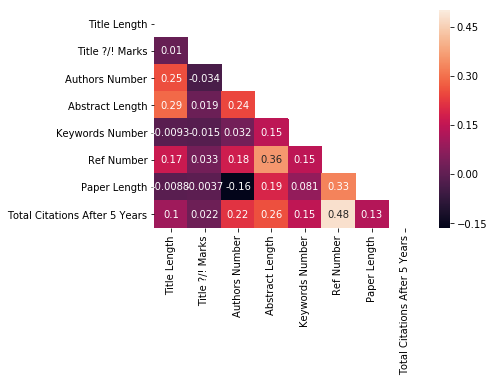

In [53]:
sf = join_sf
sf["Title Length"] = sf["Title"].apply(lambda t: len(t.split())) 
sf = sf[sf["Title Length"] > 1]
sf = sf[sf["Title Length"] < 50] # remove long titles that probably are results of problem in title parsing
sf['Title ?/! Marks'] = sf["Title"].apply(lambda t: 1 if ('!' in t or '?' in t) else 0 )
sf["Abstract Length"] = sf['abstract'].apply(lambda a: len(a.split()))
sf = sf[sf["Abstract Length"] > 10]  #  remove short abstaract
sf = sf[sf["Abstract Length"] <= 2000] #  remove long abstaract
sf.materialize()
sf["abstract_lang"] = sf["abstract"].apply(lambda t: detect_lang(t))
sf = sf[sf["abstract_lang"] == "english"]
sf['page_start'] = sf['page_start'].apply(lambda p: convert_to_int(p))
sf['page_end'] = sf['page_end'].apply(lambda p: convert_to_int(p))
sf = sf[sf['page_start'] != None]
sf = sf[sf['page_end'] != None]
sf['Paper Length'] = sf.apply(lambda p: p['page_end'] - p['page_start'] + 1)
sf['Total Citations by Year'] = sf['Total Citations by Year'].apply(lambda d: {int(k):v for k,v in d.iteritems()})
sf['Total Citations'] = sf.apply(lambda r: {int(k - r["Year"]): v for k, v in r['Total Citations by Year'].iteritems()})
sf['Total Citations After 5 Years'] = sf['Total Citations'].apply(lambda d: citation_after_years(d, 5) )
sf = sf["Year","Title Length","Title ?/! Marks", "Authors Number",  "Abstract Length", "Keywords Number", "Ref Number", "Paper Length","Total Citations After 5 Years"]
df = sf.remove_column("Year").to_dataframe()
corr = df.corr('spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, annot=True, vmax=.5)

We can also calculate the correlation for specific years and get similar results.

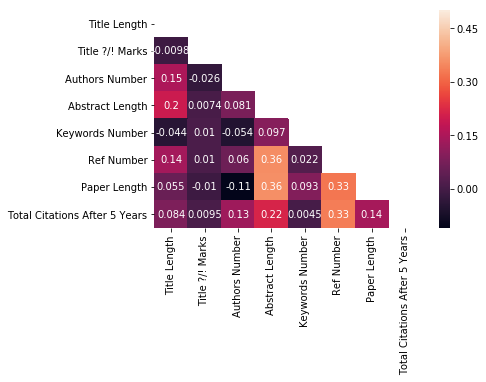

In [54]:
sf_1980 = sf[sf["Year"] == 1980]
df = sf_1980.remove_column("Year").to_dataframe()
corr = df.corr('spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, annot=True, vmax=.5)

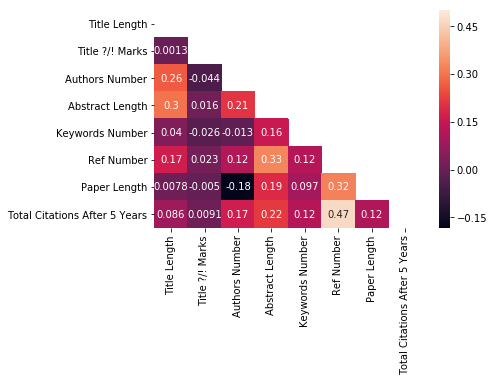

In [55]:
sf_2000 = sf[sf["Year"] == 2000]
df = sf_2000.remove_column("Year").to_dataframe()
corr = df.corr('spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, annot=True, vmax=.5)